In [1]:
import numpy as np
import matplotlib.pyplot as plt


In [2]:
class MultilayerPerceptron:
    def __init__(self, input_size, hidden_layer_sizes, output_size, activation_functions_type):
        self.input_size = input_size
        self.hidden_layer_sizes = hidden_layer_sizes
        self.output_size = output_size
        self.af_type = [af.lower() for af in activation_functions_type]
        self.layers = len(hidden_layer_sizes) + 1

        # Initialize weights with He initialization for ReLU layers
        self.weights = []
        self.biases = []
        
        prev_size = input_size
        for size in hidden_layer_sizes:
            self.weights.append(np.random.randn(prev_size, size) * np.sqrt(2. / prev_size))
            self.biases.append(np.zeros((1, size)))
            prev_size = size
        
        # Output layer initialization
        self.weights.append(np.random.randn(prev_size, output_size) * 0.01)
        self.biases.append(np.zeros((1, output_size)))

    def activation_function(self, x, type='relu'):
        type = type.lower()
        if type == 'relu':
            return np.maximum(0, x)
        elif type == 'softmax':
            exp_x = np.exp(x - np.max(x, axis=-1, keepdims=True))
            return exp_x / (np.sum(exp_x, axis=-1, keepdims=True) + 1e-8)
        elif type == 'tanh':
            return np.tanh(x)
        elif type == 'sigmoid':
            return 1 / (1 + np.exp(-x))
        elif type == 'linear':
            return x
        else:
            raise ValueError(f"Unsupported activation function: {type}")

    def activation_function_derivative(self, x, type='relu'):
        type = type.lower()
        if type == 'relu':
            return (x > 0).astype(float)
        elif type == 'softmax':
            s = self.activation_function(x, 'softmax')
            return s * (1 - s)
        elif type == 'tanh':
            return 1 - np.tanh(x)**2
        elif type == 'sigmoid':
            sig = self.activation_function(x, 'sigmoid')
            return sig * (1 - sig)
        elif type == 'linear':
            return np.ones_like(x)
        else:
            raise ValueError(f"Unsupported activation function: {type}")

    def forward(self, x):
        layer_output = x
        for i in range(self.layers):
            layer_input = np.dot(layer_output, self.weights[i]) + self.biases[i]
            layer_output = self.activation_function(layer_input, self.af_type[i])
        return layer_output

    def gradient_calculation(self, x, grad):
        layer_outputs = [x]
        layer_inputs = []
        
        # Forward pass
        for i in range(self.layers):
            layer_input = np.dot(layer_outputs[-1], self.weights[i]) + self.biases[i]
            layer_inputs.append(layer_input)
            layer_output = self.activation_function(layer_input, self.af_type[i])
            layer_outputs.append(layer_output)
        
        # Backpropagation
        delta = grad * self.activation_function_derivative(layer_inputs[-1], self.af_type[-1])
        
        grads = [{'weights': np.zeros_like(w), 'bias': np.zeros_like(b)} for w, b in zip(self.weights, self.biases)]
        
        for i in reversed(range(self.layers)):
            grads[i]['weights'] = np.dot(layer_outputs[i].T, delta)
            grads[i]['bias'] = np.sum(delta, axis=0, keepdims=True)
            
            if i > 0:
                delta = np.dot(delta, self.weights[i].T) * self.activation_function_derivative(layer_inputs[i-1], self.af_type[i-1])
        
        return grads, delta

    def train(self, x, y_true, learning_rate=0.001, epochs=100, clip_grad=1.0):
        if y_true.shape != (x.shape[0], self.output_size):
            raise ValueError(f"y_true must have shape (batch_size, {self.output_size})")
        
        for epoch in range(epochs):
            y_pred = self.forward(x)
            loss = np.mean((y_true - y_pred) ** 2)
            grad = -2 * (y_true - y_pred) / x.shape[0]
            
            grads, _ = self.gradient_calculation(x, grad)
            
            for i in range(self.layers):
                # Gradient clipping
                grads[i]['weights'] = np.clip(grads[i]['weights'], -clip_grad, clip_grad)
                grads[i]['bias'] = np.clip(grads[i]['bias'], -clip_grad, clip_grad)
                
                self.weights[i] -= learning_rate * grads[i]['weights']
                self.biases[i] -= learning_rate * grads[i]['bias']
            


In [3]:
class AUV_Nonlinear_System:
    def __init__(self, dt=0.01):
        self.dt = dt
        self.t = np.linspace(0, 50, int(50/dt))
        
        # 12 state
        self.xd = np.array([
            np.sin(self.t),       # x
            np.cos(self.t),       # y
            0.5 * self.t,         # z
            np.zeros_like(self.t),# φ
            np.zeros_like(self.t),# θ
            np.pi/4 * np.sin(0.1*self.t),  # ψ
            np.zeros_like(self.t),# u
            np.zeros_like(self.t),# v
            np.zeros_like(self.t),# w
            np.zeros_like(self.t),# p
            np.zeros_like(self.t),# q
            np.zeros_like(self.t) # r
        ]).T
        
        # System matrices
        self.M = np.diag([100, 100, 100, 50, 50, 50])
        self.D = np.diag([10, 10, 10, 5, 5, 5])
        self.Cor = np.zeros((6, 6))
        self.C_measurement = np.array([
            [0,0,1,0,0,0,0,0,0,0,0,0],
            [0,0,0,1,0,0,0,0,0,0,0,0],
            [0,0,0,0,1,0,0,0,0,0,0,0],
            [0,0,0,0,0,1,0,0,0,0,0,0]
        ])
        
        self.fault_types = {
            'normal': 0,
            'propeller_slight': 1,
            'propeller_severe': 2,
            'depth_sensor': 3,
            'load_increase': 4
        }
        
        # Initialize state
        self.reset()
        
    def reset(self):
        self.x = np.zeros((12, 1))
        self.y = np.zeros((4, 1))
        self.T_A = np.random.randn(12, 5) * 0.01
        self.T_S = np.random.randn(4, 5) * 0.01

    def coriolis_matrix(self, nu):
        u, v, w, p, q, r = nu.flatten()
        self.Cor = np.array([
            [0, 0, 0, 0, -w, v],
            [0, 0, 0, w, 0, -u],
            [0, 0, 0, -v, u, 0],
            [0, -w, v, 0, -r, q],
            [w, 0, -u, r, 0, -p],
            [-v, u, 0, -q, p, 0]
        ]) * 10
        return self.Cor
    
    def step(self, tau, fault_type='normal'):
        eta = self.x[:6]
        nu = self.x[6:]
        
        # Kinematic equations
        phi, theta, psi = eta[3:6].flatten()
        R_pos = self.rotation_matrix(phi, theta, psi)
        R_ang = np.array([
            [1, np.sin(phi)*np.tan(theta), np.cos(phi)*np.tan(theta)],
            [0, np.cos(phi), -np.sin(phi)],
            [0, np.sin(phi)/np.cos(theta), np.cos(phi)/np.cos(theta)]
        ])
        
        # Dynamic equations
        nu_dot = np.linalg.inv(self.M) @ (
            tau - self.coriolis_matrix(nu) @ nu - self.D @ nu - self.gravity_buoyancy(eta)
        )
        eta_dot = np.vstack((R_pos @ nu[:3], R_ang @ nu[3:6]))
        
        self.x[:6] += eta_dot * self.dt
        self.x[6:] += nu_dot * self.dt
        
        # Apply faults
        if fault_type != 'normal':
            fault_id = self.fault_types[fault_type]
            # Apply actuator fault
            self.x += self.T_A[:, fault_id].reshape(-1, 1) * self.dt
            # Apply sensor fault
            self.y = self.measurement() + self.T_S[:, fault_id].reshape(-1, 1)
        else:
            self.y = self.measurement()

    def rotation_matrix(self, phi, theta, psi):
        return np.array([
            [np.cos(psi)*np.cos(theta), 
             -np.sin(psi)*np.cos(phi)+np.cos(psi)*np.sin(theta)*np.sin(phi),
             np.sin(psi)*np.sin(phi)+np.cos(psi)*np.cos(phi)*np.sin(theta)],
            [np.sin(psi)*np.cos(theta), 
             np.cos(psi)*np.cos(phi)+np.sin(phi)*np.sin(theta)*np.sin(psi),
             -np.cos(psi)*np.sin(phi)+np.sin(theta)*np.sin(psi)*np.cos(phi)],
            [-np.sin(theta), np.cos(theta)*np.sin(phi), np.cos(theta)*np.cos(phi)]
        ])

    def gravity_buoyancy(self, eta):
        g = np.zeros((6, 1))
        g[2] = 9.81 * (1000 - 1025)
        return g

    def measurement(self):
        return self.C_measurement @ self.x



##  AUV Nonlinear System

In [4]:
# Initialize components
STATE_DIM = 12
MEAS_DIM = 4
CTRL_DIM = 6

controller = MultilayerPerceptron(
    input_size=24,
    hidden_layer_sizes=[64, 64],
    output_size=6,
    activation_functions_type=["relu", "relu", "linear"]
)

identifier = MultilayerPerceptron(
    input_size=6 + 12 + 12,
    hidden_layer_sizes=[64, 64],
    output_size=12,
    activation_functions_type=["relu", "relu", "linear"]
)

T_A_model = MultilayerPerceptron(
    input_size=12 + 6,
    hidden_layer_sizes=[32, 32],
    output_size=12,
    activation_functions_type=["relu", "relu", "linear"]
)

T_S_model = MultilayerPerceptron(
    input_size=12 + 6,
    hidden_layer_sizes=[32, 32],
    output_size=4,
    activation_functions_type=["relu", "relu", "linear"]
)

auv = AUV_Nonlinear_System()

# Training parameters
LEARNING_RATE = 0.0001
CLIP_GRAD = 5.0
EPOCHS = 500

# Training loop with improvements
for epoch in range(EPOCHS):
    auv.reset()
    history = {
        'x': np.zeros((len(auv.t), STATE_DIM)),
        'xhat': np.zeros((len(auv.t), STATE_DIM)),
        'u': np.zeros((len(auv.t), CTRL_DIM)),
        'T_A': np.zeros((len(auv.t), 12)),
        'T_S': np.zeros((len(auv.t), MEAS_DIM)),
        'y': np.zeros((len(auv.t), MEAS_DIM)),
        'y_hat': np.zeros((len(auv.t), MEAS_DIM))
    }
    
    for i in range(len(auv.t)):
        # Input normalization
        xc = np.concatenate([auv.x.flatten(), auv.xd[i].flatten()])
        xc_normalized = (xc - np.mean(xc)) / (np.std(xc) + 1e-8)
        
        # Controller with clipped output
        u = controller.forward(xc_normalized.reshape(1, -1))
        u = np.clip(u, -10, 10)
        tau = u.reshape(-1, 1)
        
        # Identifier with normalized input
        iden_input = np.concatenate([
            u.flatten(),
            auv.x.flatten(),
            history['T_A'][max(i-1,0)].flatten()
        ])
        iden_input_normalized = (iden_input - np.mean(iden_input)) / (np.std(iden_input) + 1e-8)
        
        # Fault estimation
        state_hat = identifier.forward(iden_input_normalized.reshape(1, -1))
        fault_input = np.concatenate([state_hat, u.reshape(1, -1)], axis=1)
        fault_input_normalized = (fault_input - np.mean(fault_input)) / (np.std(fault_input) + 1e-8)
        
        T_A_hat = T_A_model.forward(fault_input_normalized)
        T_S_hat = T_S_model.forward(fault_input_normalized)
        
        # System update
        auv.step(tau, 'propeller_slight' if 20 < i < 25 else 'normal')
        
        # Store data
        history['x'][i] = auv.x.flatten()
        history['xhat'][i] = state_hat.flatten()
        history['u'][i] = u.flatten()
        history['T_A'][i] = T_A_hat.flatten()
        history['T_S'][i] = T_S_hat.flatten()
        history['y'][i] = auv.y.flatten()
        history['y_hat'][i] = (auv.C_measurement @ state_hat.T + T_S_hat.T).flatten()
        
        # Training updates
        e_x = auv.x.reshape(1, -1) - state_hat
        e_y = auv.y.reshape(1, -1) - history['y_hat'][i].reshape(1, -1)
        
        identifier.train(iden_input_normalized.reshape(1, -1), e_x,
                        learning_rate=LEARNING_RATE, epochs=1, clip_grad=CLIP_GRAD)
        T_S_model.train(fault_input_normalized, e_y,
                        learning_rate=LEARNING_RATE, epochs=1, clip_grad=CLIP_GRAD)
        T_A_model.train(fault_input_normalized, e_x,
                        learning_rate=LEARNING_RATE, epochs=1, clip_grad=CLIP_GRAD)
        
        # Controller training
        e_tracking = state_hat[:, :6] - auv.xd[i].reshape(1, -1)[:, :6]
        controller.train(xc_normalized.reshape(1, -1), e_tracking,
                        learning_rate=LEARNING_RATE, epochs=1, clip_grad=CLIP_GRAD)
    
    
    if epoch % 10 == 0:
        print(f"Global Epoch {epoch}, Avg Loss: {np.mean(e_x**2):.4f}")

Global Epoch 0, Avg Loss: 21730.4570
Global Epoch 10, Avg Loss: 7721.2878
Global Epoch 20, Avg Loss: 5891.0111
Global Epoch 30, Avg Loss: 19923.2436
Global Epoch 40, Avg Loss: 14777.4975
Global Epoch 50, Avg Loss: 246.9997
Global Epoch 60, Avg Loss: 6213.4805
Global Epoch 70, Avg Loss: 12041.0062
Global Epoch 80, Avg Loss: 18791.7492
Global Epoch 90, Avg Loss: 6130.9093
Global Epoch 100, Avg Loss: 3055.3325
Global Epoch 110, Avg Loss: 13303.3725
Global Epoch 120, Avg Loss: 2413.7038
Global Epoch 130, Avg Loss: 581.8785
Global Epoch 140, Avg Loss: 2730.8154
Global Epoch 150, Avg Loss: 577.9286
Global Epoch 160, Avg Loss: 17103.4590
Global Epoch 170, Avg Loss: 2463.2190
Global Epoch 180, Avg Loss: 19561.4876
Global Epoch 190, Avg Loss: 12609.1523
Global Epoch 200, Avg Loss: 11089.8802
Global Epoch 210, Avg Loss: 215.9215
Global Epoch 220, Avg Loss: 2563.1532
Global Epoch 230, Avg Loss: 353.9016
Global Epoch 240, Avg Loss: 785.1768
Global Epoch 250, Avg Loss: 4312.4199
Global Epoch 260, A

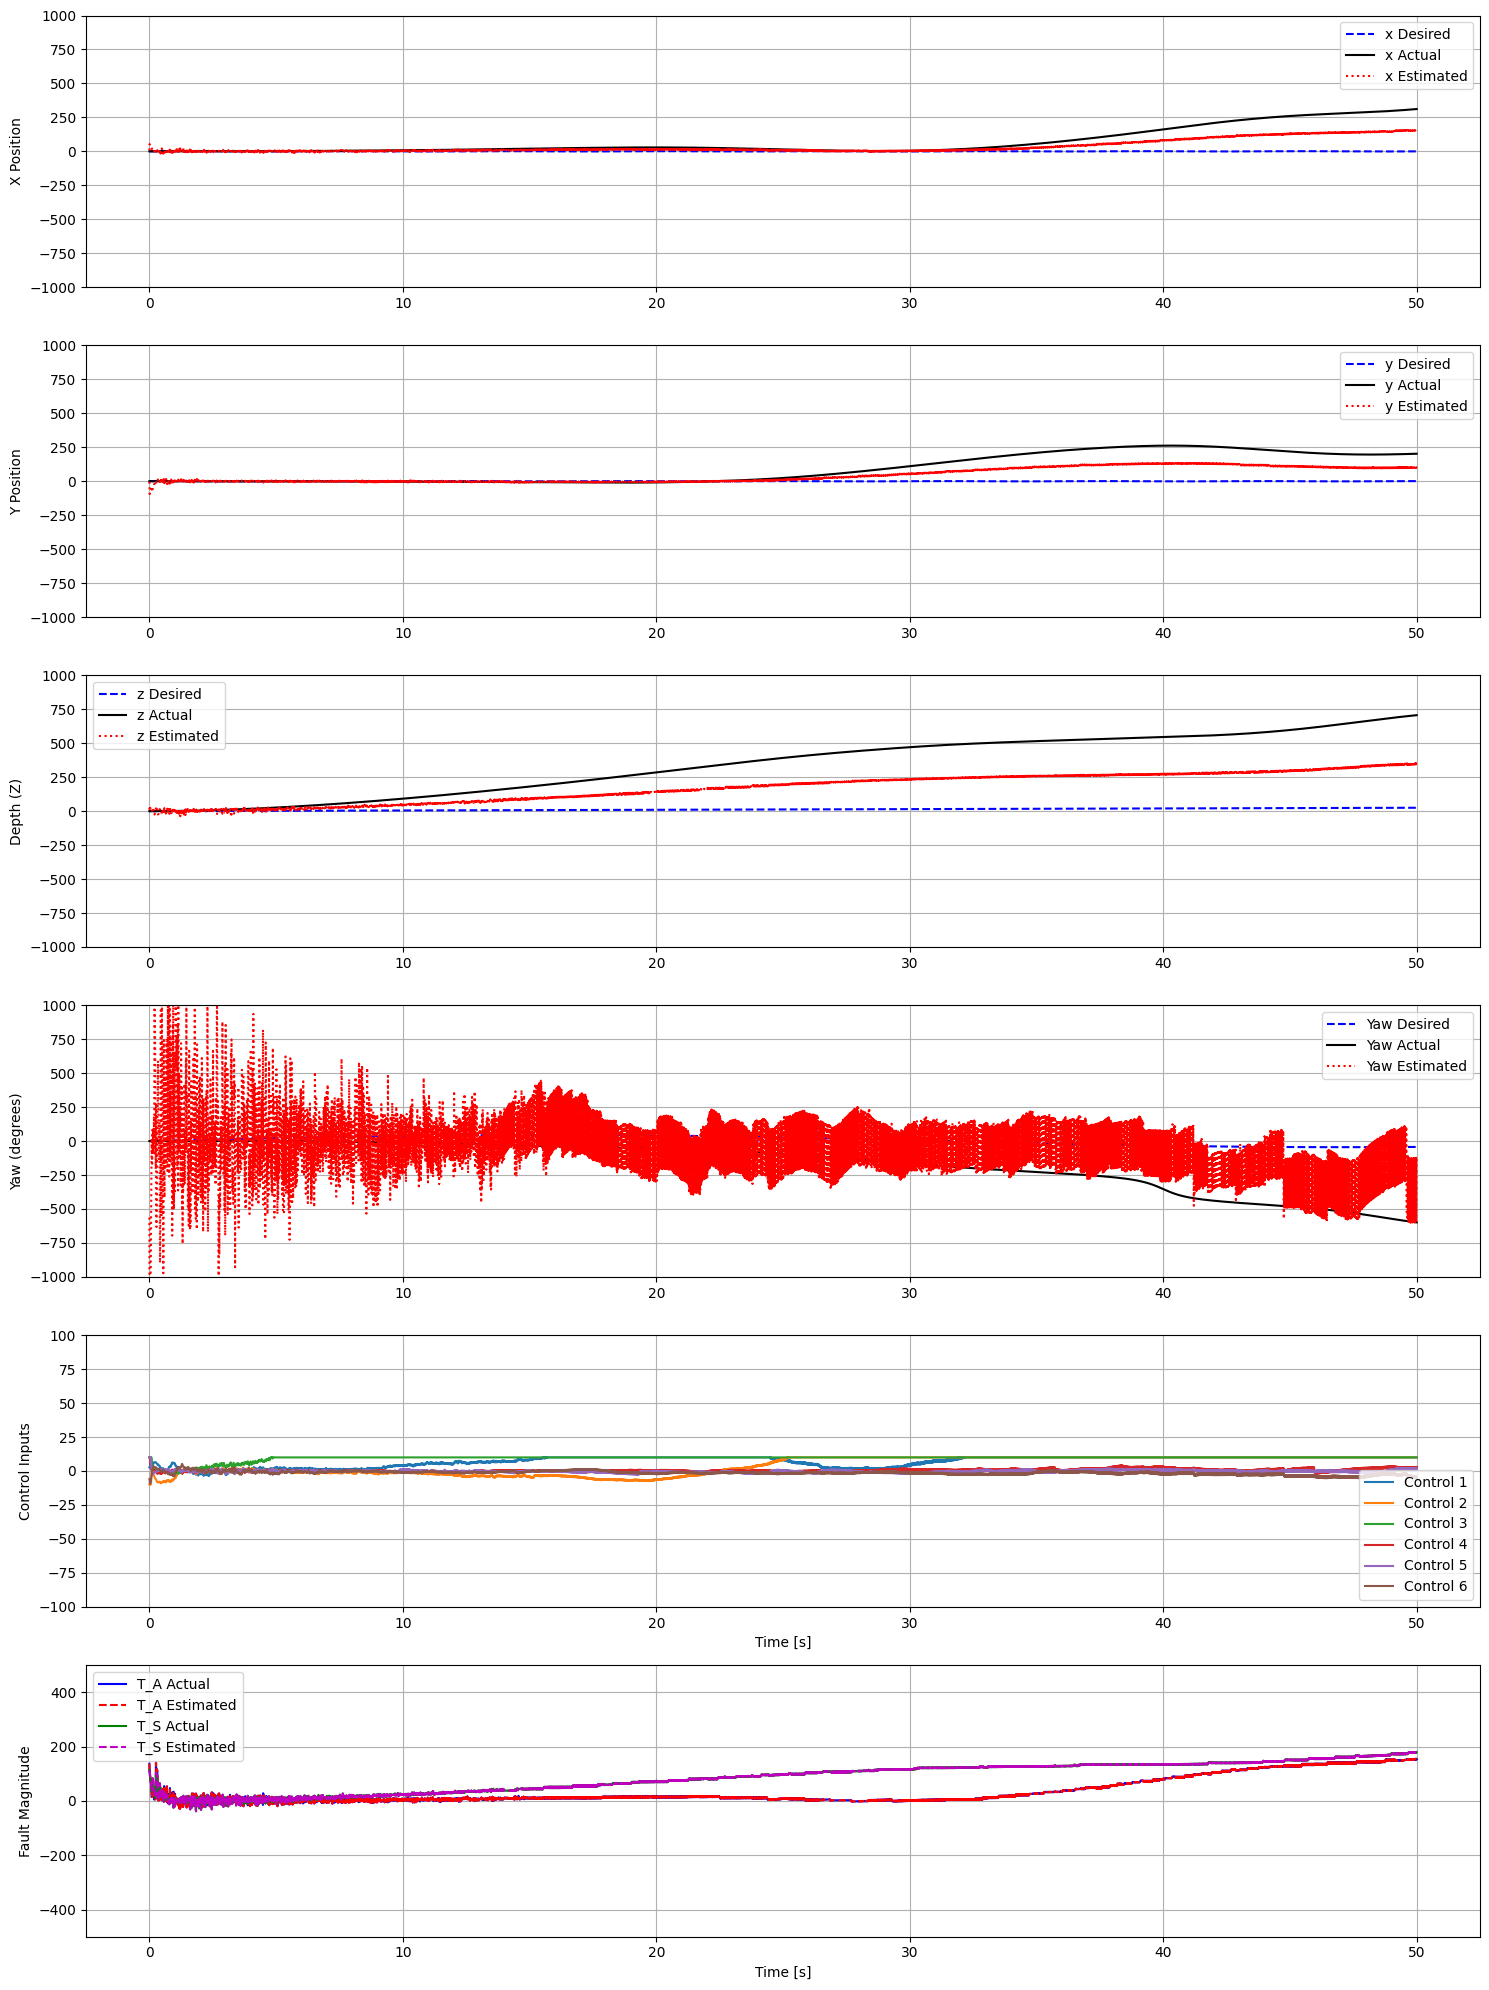

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 20))

# Plot Position States (x, y, z)
plt.subplot(6, 1, 1)
plt.plot(auv.t, auv.xd[:, 0], 'b--', label='x Desired')
plt.plot(auv.t, history['x'][:, 0], 'k-', label='x Actual')
plt.plot(auv.t, history['xhat'][:, 0], 'r:', label='x Estimated')
plt.ylabel('X Position')
plt.grid(True)
plt.ylim(-1000, 1000)
plt.legend()

plt.subplot(6, 1, 2)
plt.plot(auv.t, auv.xd[:, 1], 'b--', label='y Desired')
plt.plot(auv.t, history['x'][:, 1], 'k-', label='y Actual')
plt.plot(auv.t, history['xhat'][:, 1], 'r:', label='y Estimated')
plt.ylabel('Y Position')
plt.grid(True)
plt.ylim(-1000, 1000)

plt.legend()

plt.subplot(6, 1, 3)
plt.plot(auv.t, auv.xd[:, 2], 'b--', label='z Desired')
plt.plot(auv.t, history['x'][:, 2], 'k-', label='z Actual')
plt.plot(auv.t, history['xhat'][:, 2], 'r:', label='z Estimated')
plt.ylabel('Depth (Z)')
plt.grid(True)
plt.ylim(-1000, 1000)
plt.legend()

# Plot Orientation (roll, pitch, yaw)
plt.subplot(6, 1, 4)
plt.plot(auv.t, np.rad2deg(auv.xd[:, 5]), 'b--', label='Yaw Desired')
plt.plot(auv.t, np.rad2deg(history['x'][:, 5]), 'k-', label='Yaw Actual')
plt.plot(auv.t, np.rad2deg(history['xhat'][:, 5]), 'r:', label='Yaw Estimated')
plt.ylabel('Yaw (degrees)')
plt.grid(True)
plt.ylim(-1000, 1000)
plt.legend()

# Plot Control Inputs
plt.subplot(6, 1, 5)
for i in range(6):
    plt.plot(auv.t, history['u'][:, i], label=f'Control {i+1}')
plt.ylabel('Control Inputs')
plt.xlabel('Time [s]')
plt.grid(True)
plt.ylim(-100, 100)
plt.legend()

# Plot Fault Estimates
plt.subplot(6, 1, 6)
plt.plot(auv.t, history['T_A'][:, 0], 'b-', label='T_A Actual')
plt.plot(auv.t, history['T_A'][:, 0], 'r--', label='T_A Estimated')
plt.plot(auv.t, history['T_S'][:, 0], 'g-', label='T_S Actual')
plt.plot(auv.t, history['T_S'][:, 0], 'm--', label='T_S Estimated')
plt.ylabel('Fault Magnitude')
plt.xlabel('Time [s]')
plt.grid(True)
plt.ylim(-500, 500)
plt.legend()

plt.tight_layout()
plt.show()